A code taken from A. Wietek (ed_basic):

In [36]:
# -*- coding: utf-8 -*-
'''
Solution to Exercise 1a

:author: Alexander Wietek
:email: alexander.wietek@uibk.ac.at
:year: 2018
'''
from __future__ import absolute_import, division, print_function

import numpy as np
import scipy as sp
from scipy import sparse
from scipy import linalg
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA

# Step 1: just copied this function from hamiltonian_tfi.py
def get_hamiltonian_sparse(L, J, hx):
    '''
    Creates the Hamiltonian of the Transverse Field Ising model
    '''

    def get_site_value(state, site):
        ''' Function to get local value at a given site '''
        return (state >> site) & 1

    def hilbertspace_dimension(L):
        ''' return dimension of hilbertspace '''
        return 2**L

    # Define chain lattice
    ising_bonds = [(site, (site+1)%L) for site in range(L)]

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(hilbertspace_dimension(L)):

        # Apply Ising bonds
        ising_diagonal = 0
        for bond in ising_bonds:
            if get_site_value(state, bond[0]) == get_site_value(state, bond[1]):
                ising_diagonal += J
            else:
                ising_diagonal -= J
        hamiltonian_rows.append(state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(ising_diagonal)

        # Apply transverse field
        for site in range(L):

            # Flip spin at site
            new_state = state ^ (1 << site)
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx)

    return hamiltonian_rows, hamiltonian_cols, hamiltonian_data

In [42]:
# Step 2: Compute the energies of the lowest 10 eigenvalues for x=0...2
# and plot results
L=4
J=1
# n_lowest_eigenvalues = 50
#n_lowest_eigenvalues = 50 #for sparse matrix, not all eigs are recovered
n_lowest_eigenvalues = 2**4 #all eigs are obtained for small system
n_hx = 20
all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))
hx_values = np.linspace(0,2,n_hx)
for i in range(n_hx):
    hx = hx_values[i]
    rows, cols, data = get_hamiltonian_sparse(L, J, hx)
    #using a sparse matrix
    # hamiltonian = sp.sparse.csr_matrix((data, (rows, cols)))
    # eigs = sp.sparse.linalg.eigsh(hamiltonian, k=n_lowest_eigenvalues,
    #                               which='SA', return_eigenvectors=False,
    #                               maxiter=1000, ncv = 10*n_lowest_eigenvalues)
    simple_matrix = np.zeros((2**L, 2**L))
    for k in range(len(rows)):
        simple_matrix[rows[k], cols[k]] = data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    all_eigenvalues[i,:] = np.sort(np.real(eigs))
    #print(eigs)
    #print(hx, eigs)


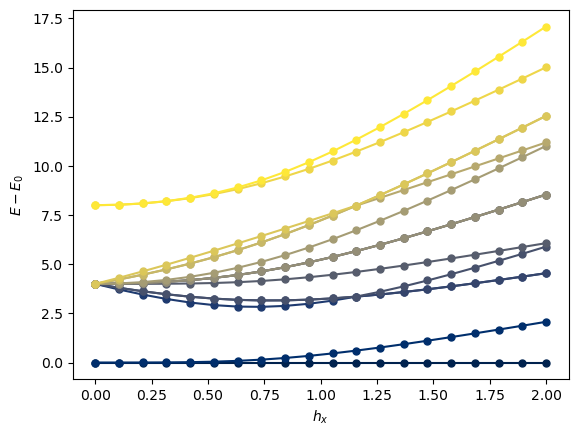

In [45]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
plt.ylabel(r"$E - E_0$")
#plt.ylim(-0.1, 6)
plt.show()

In [46]:
def perm_parity(lst):
    '''\
    Given a permutation of the digits 0..N in order as a list, 
    returns its parity (or sign): +1 for even parity; -1 for odd.
    '''
    parity = 1
    for i in range(0,len(lst)-1):
        if lst[i] != i:
            parity *= -1
            mn = min(range(i,len(lst)), key=lst.__getitem__)
            lst[i],lst[mn] = lst[mn],lst[i]
    return parity    

from itertools import permutations

for p in permutations(range(4)):
    l = list(p)
    print("%2i %r" % (perm_parity(l), p))

 1 (0, 1, 2, 3)
-1 (0, 1, 3, 2)
-1 (0, 2, 1, 3)
 1 (0, 2, 3, 1)
 1 (0, 3, 1, 2)
-1 (0, 3, 2, 1)
-1 (1, 0, 2, 3)
 1 (1, 0, 3, 2)
 1 (1, 2, 0, 3)
-1 (1, 2, 3, 0)
-1 (1, 3, 0, 2)
 1 (1, 3, 2, 0)
 1 (2, 0, 1, 3)
-1 (2, 0, 3, 1)
-1 (2, 1, 0, 3)
 1 (2, 1, 3, 0)
 1 (2, 3, 0, 1)
-1 (2, 3, 1, 0)
-1 (3, 0, 1, 2)
 1 (3, 0, 2, 1)
 1 (3, 1, 0, 2)
-1 (3, 1, 2, 0)
-1 (3, 2, 0, 1)
 1 (3, 2, 1, 0)


In [23]:
[p for p in permutations(range(4))]

[(0, 1, 2, 3),
 (0, 1, 3, 2),
 (0, 2, 1, 3),
 (0, 2, 3, 1),
 (0, 3, 1, 2),
 (0, 3, 2, 1),
 (1, 0, 2, 3),
 (1, 0, 3, 2),
 (1, 2, 0, 3),
 (1, 2, 3, 0),
 (1, 3, 0, 2),
 (1, 3, 2, 0),
 (2, 0, 1, 3),
 (2, 0, 3, 1),
 (2, 1, 0, 3),
 (2, 1, 3, 0),
 (2, 3, 0, 1),
 (2, 3, 1, 0),
 (3, 0, 1, 2),
 (3, 0, 2, 1),
 (3, 1, 0, 2),
 (3, 1, 2, 0),
 (3, 2, 0, 1),
 (3, 2, 1, 0)]

In [68]:
# Step 1: just copied this function from hamiltonian_tfi.py
def get_gadget_sparse(C, hx):
    L = 4
    '''
    Creates the Hamiltonian of the Transverse Field Ising model
    '''

    def get_site_value(state, site):
        ''' Function to get local value at a given site '''
        return (state >> site) & 1

    def hilbertspace_dimension(L):
        ''' return dimension of hilbertspace '''
        return 2**L

    # Define chain lattice
    plaquettes = [p for p in permutations(range(4))]

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(hilbertspace_dimension(L)):

        # Apply Ising bonds
        #parity_value = 0
        # for perm in plaquettes:
        #     vals = [get_site_value(state, perm[k]) for k in range(L)]
        #     product = np.prod(vals)
        #     # if perm_parity(list(perm)) == 1:
        #     #     parity_value += C*product
        #     # else:
        #     #     parity_value -= C*product
        #     parity_value += C*product
        vals = np.array([(2*get_site_value(state, plaquettes[0][k]) - 1) for k in range(L)])
        #print(vals)
        parity_value = np.prod(vals)

        hamiltonian_rows.append(state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(parity_value)

        # Apply transverse field
        for site in range(L):

            # Flip spin at site
            new_state = state ^ (1 << site)
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx)

    return hamiltonian_rows, hamiltonian_cols, hamiltonian_data

In [114]:
def get_site_value(state, site):
    ''' Function to get local value at a given site '''
    return (state >> site) & 1


n_sites = 4;
n_lowest_eigenvalues = 2**n_sites #all eigs are obtained for small system
n_hx = 20
C=1
all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))
hx_values = np.linspace(0,2,n_hx)

#plaquettes = [(0,1,2,3), (2,4,5,6)]
plaquettes = [(0,1,2,3)]

for i in range(n_hx):
    hx = hx_values[i]

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(2**(n_sites)):
        for l in range(len(plaquettes)):
            vals = np.array([(2*get_site_value(state, plaquettes[l][k]) - 1) for k in range(L)])
            #print(vals)
            parity_value = np.prod(vals)

            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(parity_value)

        # Apply transverse field
        for site in range(L):

            # Flip spin at site
            new_state = state ^ (1 << site)
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx)

    simple_matrix = np.zeros((2**n_sites, 2**n_sites))
    for k in range(len(rows)):
        simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] = hamiltonian_data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    all_eigenvalues[i,:] = np.sort(np.real(eigs))

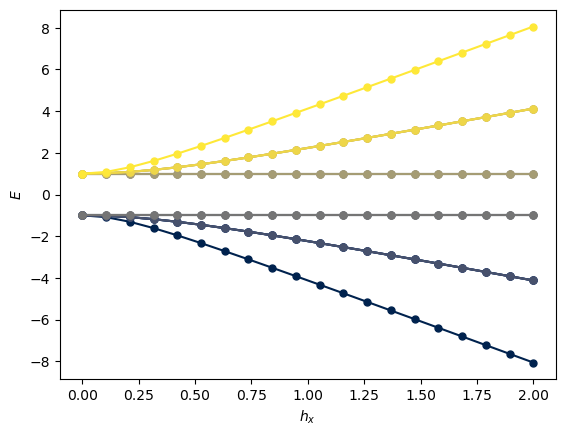

In [115]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - 0*gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
# plt.ylabel(r"$E - E_0$")
plt.ylabel(r"$E$")
#plt.ylim(-0.1, 6)
plt.show()

In [212]:
hx = 0.5
n_sites = 4;
n_lowest_eigenvalues = 2**n_sites #all eigs are obtained for small system
n_hx = 20
C=1
all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))
hx_values = np.linspace(0,2,n_hx)

#plaquettes = [(0,1,2,3), (2,4,5,6)]
plaquettes = [(0,1,2,3)]


# Empty lists for sparse matrix
hamiltonian_rows = []
hamiltonian_cols = []
hamiltonian_data = []

# Run through all spin configurations
for state in range(2**(n_sites)):
    for l in range(len(plaquettes)):
        vals = np.array([(2*get_site_value(state, plaquettes[l][k]) - 1) for k in range(L)])
        #print(vals)
        parity_value = np.prod(vals)

        hamiltonian_rows.append(state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(parity_value)

    # Apply transverse field
    for site in range(L):

        # Flip spin at site
        new_state = state ^ (1 << site)
        hamiltonian_rows.append(new_state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(hx)

simple_matrix = np.zeros((2**n_sites, 2**n_sites))
for k in range(len(rows)):
    simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] = hamiltonian_data[k]

eigs, eigenvectors = LA.eig(simple_matrix)
print(np.sort(eigs))

[-2.23606798 -1.41421356 -1.41421356 -1.41421356 -1.41421356 -1.
 -1.         -1.          1.          1.          1.          1.41421356
  1.41421356  1.41421356  1.41421356  2.23606798]


# for the parity gadget

In [213]:
#parity -1 gadget
J_dict = {(51, 532): -20,
 (55, 532): -20,
 (55, 528): -20,
 (51, 528): -20,
 (43, 532): 1,
 (43, 528): 1,
 (51, 520): 1,
 (51, 524): 1,
 (47, 528): 1,
 (47, 532): 1,
 (55, 520): 1,
 (55, 524): 1,
 (43, 520): 1,
 (43, 524): 1,
 (47, 520): 1,
 (47, 524): 1,
 (43, 47): 1,
 (520, 524): 1}

h_dict = {520: 0, 43: 0, 524: 0, 47: 0, 528: 0, 51: 0, 532: 0, 55: 0}

index_to_site = {}
site_to_index = {}

index = 0
for key in h_dict.keys():
    index_to_site.update({index:key})
    site_to_index.update({key:index})
    index += 1

In [234]:
#This is a problematic gadget
J_dict = {(51, 532): -2,
 (55, 532): -2,
 (55, 528): -2,
 (51, 528): -2,
 (51, 520): -0.5,
 (55, 520): -0.5,
 (43, 528): -0.5,
 (43, 532): -0.5,
 (51, 524): -0.5,
 (55, 524): -0.5,
 (47, 528): -0.5,
 (47, 532): -0.5}

h_dict = {520: 0.625,
 43: 0.625,
 524: 0.625,
 47: 0.625,
 51: -0.5,
 532: -0.5,
 528: -0.5,
 55: -0.5}

index_to_site = {}
site_to_index = {}

index = 0
for key in h_dict.keys():
    index_to_site.update({index:key})
    site_to_index.update({key:index})
    index += 1

In [242]:
J_dict = {(51, 528): -4,
 (55, 524): 2,
 (55, 520): 2,
 (51, 55): 2,
 (528, 532): 2,
 (43, 532): 2,
 (47, 532): 2,
 (51, 520): 1,
 (520, 524): 1,
 (43, 528): 1,
 (51, 524): 1,
 (43, 47): 1,
 (47, 528): 1}

h_dict = {532: -2, 55: -2, 520: -1, 43: -1, 47: -1, 524: -1, 51: -1, 528: -1}

index_to_site = {}
site_to_index = {}

index = 0
for key in h_dict.keys():
    index_to_site.update({index:key})
    site_to_index.update({key:index})
    index += 1

In [250]:

n_sites = len(index_to_site);
n_lowest_eigenvalues = 2**n_sites #all eigs are obtained for small system
n_hx = 20
max_hx = 1.0
all_eigenvalues = np.zeros((n_hx,n_lowest_eigenvalues))
hx_values = np.linspace(0,max_hx,n_hx)
chain_sites = [51, 55, 528, 532]

for i in range(n_hx):
    hx = hx_values[i]

    # Empty lists for sparse matrix
    hamiltonian_rows = []
    hamiltonian_cols = []
    hamiltonian_data = []

    # Run through all spin configurations
    for state in range(2**(n_sites)):
        for bond, value in J_dict.items():
            vals = np.array([(2*get_site_value(state, site_to_index[bond[k]]) - 1) for k in range(2)])
            #print(vals)
            #print(vals)
            J_interactions = value*np.prod(vals)
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(J_interactions)

        # Apply h field
        for site in range(n_sites):
            val = 2*get_site_value(state, site) - 1
            hamiltonian_rows.append(state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(h_dict[index_to_site[site]]*val)

        # Apply transverse field
        for site in range(n_sites):
            # Flip spin at site
            new_state = state ^ (1 << site)
            delay = 1.0
            if index_to_site[site] in chain_sites:
                delay = 0.01
            hamiltonian_rows.append(new_state)
            hamiltonian_cols.append(state)
            hamiltonian_data.append(hx*delay)

    simple_matrix = np.zeros((2**n_sites, 2**n_sites))
    for k in range(len(hamiltonian_rows)):
        simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] += hamiltonian_data[k]

    eigs, eigenvectors = LA.eig(simple_matrix)

    all_eigenvalues[i,:] = np.sort(np.real(eigs))

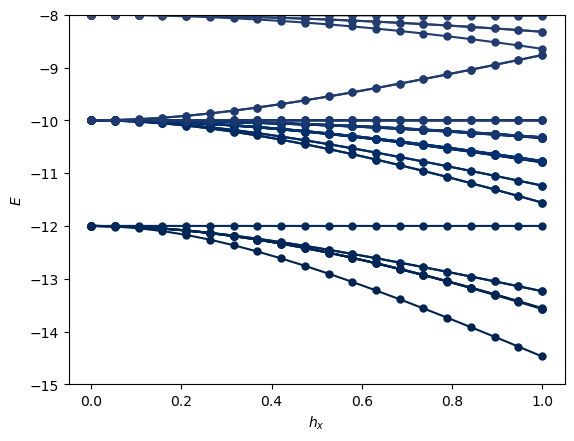

In [251]:
gs_ene = np.array([min(all_eigenvalues[i,:]) for i in range(n_hx)])
colors = plt.cm.cividis(np.linspace(0, 1, n_lowest_eigenvalues))
for j in range(n_lowest_eigenvalues):
    some_index_eigs = all_eigenvalues[:,j]
    plt.plot(hx_values, some_index_eigs - 0*gs_ene, 'o-', markersize = 5, color = colors[j])
plt.xlabel(r"$h_x$")
# plt.ylabel(r"$E - E_0$")
plt.ylabel(r"$E$")
plt.ylim(-15, -8)
plt.show()

In [245]:
hx = 0.0

# Empty lists for sparse matrix
hamiltonian_rows = []
hamiltonian_cols = []
hamiltonian_data = []

# Run through all spin configurations
for state in range(2**(n_sites)):
    for bond, value in J_dict.items():
        vals = np.array([(2*get_site_value(state, site_to_index[bond[k]]) - 1) for k in range(2)])
        #print(vals)
        #print(vals)
        J_interactions = value*np.prod(vals)
        hamiltonian_rows.append(state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(J_interactions)

    # Apply h field
    for site in range(n_sites):
        val = 2*get_site_value(state, site) - 1
        hamiltonian_rows.append(state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(h_dict[index_to_site[site]]*val)

    for site in range(n_sites):
        # Flip spin at site
        new_state = state ^ (1 << site)
        delay = 1.0
        if index_to_site[site] in chain_sites:
            delay = 0.01
        hamiltonian_rows.append(new_state)
        hamiltonian_cols.append(state)
        hamiltonian_data.append(hx*delay)


simple_matrix = np.zeros((2**n_sites, 2**n_sites))
for k in range(len(hamiltonian_rows)):
    simple_matrix[hamiltonian_rows[k], hamiltonian_cols[k]] += hamiltonian_data[k]

eigs, eigenvectors = LA.eig(simple_matrix)

In [246]:
print(np.sort(np.real(eigs)))

[-12. -12. -12. -12. -12. -12. -12. -12. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10.  -8.  -8.  -8.  -8.  -8.  -8.
  -8.  -8.  -8.  -8.  -8.  -8.  -8.  -8.  -8.  -8.  -8.  -8.  -8.  -8.
  -8.  -8.  -8.  -8.  -8.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.
  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.  -4.
  -4.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.  -2.
  -2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.   4.   4.
   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.
   4.   4.   4.   4.   4.   4.   4.   6.   6.   6.   6.   6.   6.   6.
   6. 